### Model to classify and locate muons, electrons and alphas 

Labels: 0 electron, 1 muon, 2 alpha
* [Creating training and validation generators](#Creating-training-and-validation-generators)
* [Model 1: 1002 neurons, 202 neurons for localization, dropouts, callbacks](#Model-1:-1002-neurons,-202-neurons-for-localization,-dropouts,-callbacks)
* [Model 2: 2002 neurons, callbacks](#Model-2:-2002-neurons,-callbacks)
* [Model 4: 1002 neurons, 202 neurons for localization, dropouts, callbacks](#Model-4:-1002-neurons,-202-neurons-for-localization,-dropouts,-callbacks)
* [Model 5: 3002 neurons, callbacks (best model)](#Model-5:-3002-neurons,-callbacks-(best-model))

In [1]:
import matplotlib

In [2]:
#code to plot the confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize= 16)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize= 16)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18)
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j], fontsize=18),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=18)
    plt.grid(b=False)
    plt.xlim(-0.5, 2.5)
    plt.ylim(2.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.show()
    fig.savefig('conf_mat.png')

In [3]:
#code to plot tracks and their locations and predictions

def plot_loc_class(n, y_pred, y_labels, loc_labels, loc_pred):
    #n is the rows of images to display
    
    fig = plt.figure(figsize=(80, 50))

    for i in range(n):
        # display first row
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_energy[i], cmap='Reds')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Prediction: {}, Truth: {}'.format(y_pred[i], y_labels[i]), fontsize=80)

        # Create a Rectangle patch
        rect_true = matplotlib.patches.Rectangle((loc_labels[i,0],loc_labels[i,1]),
                                                 loc_labels[i,3],loc_labels[i,2],linewidth=3,
                                                 edgecolor='g',facecolor='none')
        rect_pred = matplotlib.patches.Rectangle((loc_pred[i,0],loc_pred[i,1]),
                                                 loc_pred[i,3],loc_pred[i,2],
                                                 linewidth=3,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_true)
        ax.add_patch(rect_pred)

        # display second row
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(X_energy[i+n], cmap='Reds')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Prediction: {}, Truth: {}'.format(y_pred[i+n], y_labels[i+n]), fontsize=80)

        # Create a Rectangle patch
        rect_true = matplotlib.patches.Rectangle((loc_labels[i+n,0],loc_labels[i+n,1]),
                                                 loc_labels[i+n,3],loc_labels[i+n,2],linewidth=3,
                                                 edgecolor='g',facecolor='none')
        rect_pred = matplotlib.patches.Rectangle((loc_pred[i+n,0],loc_pred[i+n,1]),
                                                 loc_pred[i+n,3],loc_pred[i+n,2],
                                                 linewidth=3,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_true)
        ax.add_patch(rect_pred)
    
    plt.show()
    fig.savefig('location.png')

In [4]:
#code to compute the intersection over union metric for the location problem

def I_o_U(y_true, y_pred):
    
    results = []
    
    for i in range(y_true.shape[0]):

        box1 = dict()
        box2 = dict()

        box1['x1'] = y_true[i,0] #x-coordinate of bottom left corner
        box1['y1'] = y_true[i,1] #y-coordinate of bottom left corner
        box1['h'] = y_true[i,2] #height of the box
        box1['w'] = y_true[i,3] #width of the box

        box2['x1'] = y_pred[i,0] 
        box2['y1'] = y_pred[i,1]
        box2['h'] = y_pred[i,2]
        box2['w'] = y_pred[i,3]

        # calculating coordiantes for the top right corner of both boxes
        box1['x2'] = box1['x1']+box1['w']
        box1['y2'] = box1['y1']+box1['h']

        box2['x2'] = box2['x1']+box2['w']
        box2['y2'] = box2['y1']+box2['h']

        # determine the coordinates of the intersection rectangle
        x_left = max(box1['x1'], box2['x1'])
        y_top = max(box1['y1'], box2['y1'])
        x_right = min(box1['x2'], box2['x2'])
        y_bottom = min(box1['y2'], box2['y2'])
        
        if x_right < x_left or y_bottom < y_top:
            int_ov_un = 0.0
        else:
            area_inter = (x_right - x_left) * (y_bottom - y_top)

            #area of each box
            area_box1 = box1['w']*box1['h']
            area_box2 = box2['w']*box2['h']

            #area of the union of the boxes
            area_union = area_box1 + area_box2 - area_inter

            #area of the intersection over union
            int_ov_un = area_inter / area_union
        
        results.append(int_ov_un)
        
    results=np.mean(results)
    return results

In [5]:
#code to generate true labels for classification and its correspondent energy

def test_generator_XY2(inputs, shuffle=True):
    while True:
    # Create list of indices
        idxs = np.arange(len(inputs))

        if shuffle:
            np.random.shuffle(idxs)
        
        list_labels = []
        distributionX = []
        
        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
            batch_X.append(data)

            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape(batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4])
            
            y1_batch = label[:,0:3] #class label
            y2_batch = label[:,3:7] #location
            
            list_labels.append(label)
            distributionX.append(batch_X)
            
            yield(batch_X, {'output1': y1_batch, 'output2': y2_batch})
            
        list_labels = np.array(list_labels)
        list_labels.flatten()

        distributionX = np.array(distributionX)
        distributionX.flatten()
        
        np.save('energy_distribution', distributionX)
        np.save('labels' , list_labels)

In [6]:
#code to compute the new loss score for the location problem using the L2 loss function

from keras import backend as K

def l2(y_true, y_pred):
    return K.sum((K.square(y_pred - y_true)))

Using TensorFlow backend.


In [7]:
import keras
from keras import layers, models, optimizers
from keras import callbacks

In [8]:
window_y, window_x = 242, 192 #shape of each image

In [9]:
import glob
import os, shutil
from sklearn.metrics import classification_report

### Creating training and validation generators
We need to create a numpy array (X) with the path to each npz file. Each npz contains 64 npy (batch_size), so basically, one npz is one batch. 
* For the training batchs:

In [ ]:
path_tr = 'Data/eVSmuVSa_LocTrain/'
files_tr = os.listdir(path_tr)

X = np.empty(shape=(len(files_tr),), dtype=object)

for index, file in enumerate(files_tr):     
    X[index] = os.path.join(path_tr, files_tr[index]) 

In [ ]:
X.shape #we have 171 batchs (npz files) for the training

In [ ]:
def data_generator2(inputs, shuffle=True):
     while True:
    # Create list of indices
        idxs = np.arange(len(inputs))
        if shuffle:
            np.random.shuffle(idxs)

        for i in idxs:
            batch_X = []

            data = np.load(inputs[i])['X']
            label = np.load(inputs[i])['y']
 
            batch_X.append(data)


            batch_X = np.array(batch_X)
            batch_X = batch_X.reshape((batch_X.shape[1],batch_X.shape[2], batch_X.shape[3], batch_X.shape[4]))
            batch_y = label
            
            y1_batch = batch_y[:,0:3] #class label
            y2_batch = batch_y[:,3:7] #location
            
            yield(batch_X, {'output1': y1_batch, 'output2': y2_batch})

In [ ]:
train_gen =  data_generator2(inputs=X) #training data generator

In [ ]:
type(train_gen)

* Similary for the validation data:

In [14]:
path_v = 'Data/eVSmuVSa_LocVal/'
files_v = os.listdir(path_v)

#X is a numpy array of the baths to the npz files, where each one contains a batch of npy
X = np.empty(shape=(len(files_v),), dtype=object)

for index, file in enumerate(files_v):     
    X[index] = os.path.join(path_v, files_v[index]) 

In [15]:
X.shape #this is how many batches we have of validation data

(56,)

In [16]:
val_gen = data_generator2(inputs=X)

### Model 1: 1002 neurons, 202 neurons for localization, dropouts, callbacks

In [17]:
inputs = keras.Input(shape=(window_y, window_x, 1))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
block_output = layers.MaxPooling2D(2)(x)


out = layers.Flatten()(block_output)

x = layers.Dropout(0.5)(out)
x = layers.Dense(1002, activation='relu')(x)
x = layers.Dropout(0.25)(x)

output1 = layers.Dense(3, activation='softmax', name='output1')(x) #classes: electron, noise, muon

output2 = layers.Dense(202, activation='relu')(x)
output2 = layers.Dense(4)(output2) #x, y, height, width
output2 = layers.LeakyReLU(alpha=0.3, name='output2')(output2)

model = keras.Model(input=inputs, output=[output1, output2], name='model_1')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 242, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 190, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 95, 32)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 118, 93, 32)  9248        max_pooling2d_1[0][0]            
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_1", inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [19]:
#early stopping to avoid overfitting

my_callbacks = [
    callbacks.EarlyStopping(monitor ='val_loss', patience=6)
]

In [20]:
#define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses={'output1': 'categorical_crossentropy', 'output2': l2}
alpha = 0.87
lossWeights = {"output1": alpha, "output2": 1-alpha}

model.compile(optimizer=optimizers.RMSprop(lr= 1e-3), loss= losses, 
              loss_weights= lossWeights, metrics=['accuracy'])

In [21]:
H1 = model.fit_generator(train_gen, validation_data=val_gen ,epochs=40, 
                         steps_per_epoch= 171, validation_steps= 56, callbacks = my_callbacks)


Epoch 1/40
171/171 [==============================] - 34s 201ms/step - loss: 8.4567 - output1_loss: 0.9780 - output2_loss: 58.5063 - output1_accuracy: 0.4748 - output2_accuracy: 0.8713 - val_loss: 3.7808 - val_output1_loss: 0.9743 - val_output2_loss: 16.0210 - val_output1_accuracy: 0.4654 - val_output2_accuracy: 0.9406
Epoch 2/40
171/171 [==============================] - 26s 155ms/step - loss: 3.5263 - output1_loss: 0.9522 - output2_loss: 20.7528 - output1_accuracy: 0.5004 - output2_accuracy: 0.9335 - val_loss: 2.6708 - val_output1_loss: 0.8841 - val_output2_loss: 15.6847 - val_output1_accuracy: 0.5823 - val_output2_accuracy: 0.9509
Epoch 3/40
171/171 [==============================] - 28s 166ms/step - loss: 2.8867 - output1_loss: 0.8094 - output2_loss: 16.7885 - output1_accuracy: 0.6096 - output2_accuracy: 0.9397 - val_loss: 2.1862 - val_output1_loss: 0.7155 - val_output2_loss: 14.6590 - val_output1_accuracy: 0.6521 - val_output2_accuracy: 0.9269
Epoch 4/40
171/171 [================

In [22]:
model.save('models/e_mu_a_Loc1.h5')

In [ ]:
keras.utils.plot_model(model, 'models/model1.png', show_shapes=True)

* Creating the testing data from the data generator:

In [24]:
path_t = 'Data/eVSmuVSa_LocTest/'
files_t = os.listdir(path_t)

X = np.empty(shape=(len(files_t),), dtype=object)

for index, file in enumerate(files_t):     
    X[index] = os.path.join(path_t, files_t[index]) 

In [25]:
X.shape

(58,)

In [26]:
test_gen = data_generator2(inputs=X)

Now we can evaluate model to get the accuracy in the test date:

In [27]:
loss_t, loss_1, loss_2, acc_1, acc_2 = model.evaluate_generator(test_gen, steps=58)
print('Accuracy for classification: {:5.2f}%'.format(100*acc_1))

Accuracy for classification: 81.52%


Finally we predict, to draw the confusion matrix:

In [28]:
#functions that generate true labels, true localizations and energy


def gen_true_y():
    true_labels = np.load('labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1], true_labels.shape[2])
    true_labels = np.argmax(true_labels[:,0:3], axis=1)
    
    return true_labels

def gen_true_loc():
    true_labels = np.load('labels.npy')
    true_labels = true_labels.reshape(true_labels.shape[0]*true_labels.shape[1], true_labels.shape[2])
    true_labels = true_labels[:,3:]
    
    return true_labels

def get_energy():
    X_energy = np.load('energy_distribution.npy')
    X_energy = X_energy.reshape(X_energy.shape[0]* X_energy.shape[1], X_energy.shape[2], X_energy.shape[3]) 
    return X_energy

In [29]:
pred1 = model.predict_generator(test_generator_XY2(X), steps=58)

y_pred1 = pred1[0] #predicted classification 
y_pred1 = np.argmax(y_pred1, axis=1)

loc_pred1 = pred1[1] #predicted location

In [31]:
#data distribution
X_energy = get_energy()

#true classification labels
y_labels1 = gen_true_y()

#true localization labels
loc_labels1 = gen_true_loc()

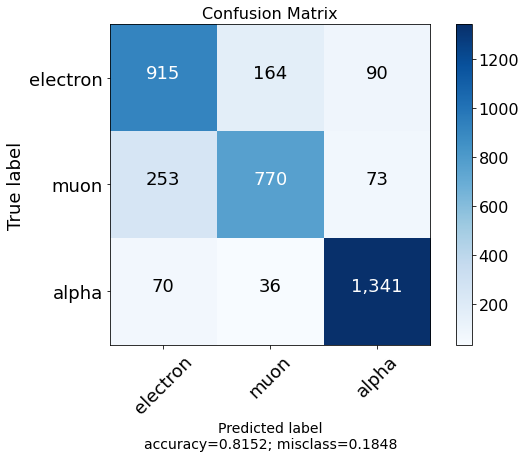

In [32]:
conf1 = confusion_matrix(y_labels1, y_pred1, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

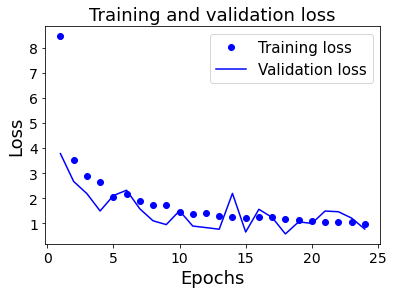

In [33]:
history_n1 = H1.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

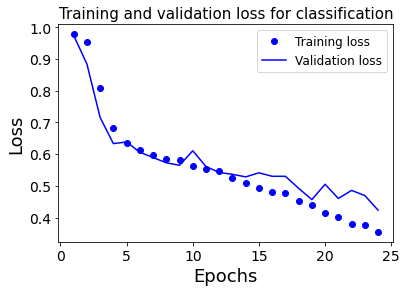

In [34]:
history_n1 = H1.history
loss_values_n1 = history_n1['output1_loss']
val_loss_values_n1 = history_n1['val_output1_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for classification', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

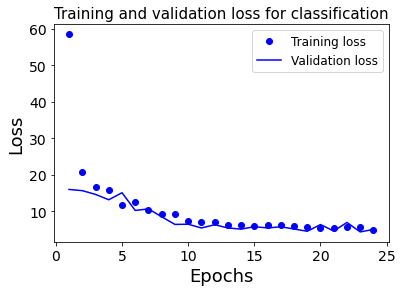

In [35]:
history_n1 = H1.history
loss_values_n1 = history_n1['output2_loss']
val_loss_values_n1 = history_n1['val_output2_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for classification', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [36]:
target_names=['electron', 'muon','alpha']

In [37]:
print(classification_report(y_labels1, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

    electron       0.74      0.78      0.76      1169
        muon       0.79      0.70      0.75      1096
       alpha       0.89      0.93      0.91      1447

    accuracy                           0.82      3712
   macro avg       0.81      0.80      0.80      3712
weighted avg       0.81      0.82      0.81      3712



In [38]:
#mean and standar deviation for the training dataset of the parameters that define the location of a particle

m_loc = 57.007903874269005
std_loc = 64.09855334908328

In [39]:
loc_pred1_ = loc_pred1 * std_loc + m_loc
loc_labels1_ = loc_labels1 * std_loc + m_loc

In [40]:
I_o_U(loc_labels1_, loc_pred1_)

0.17978598243497476

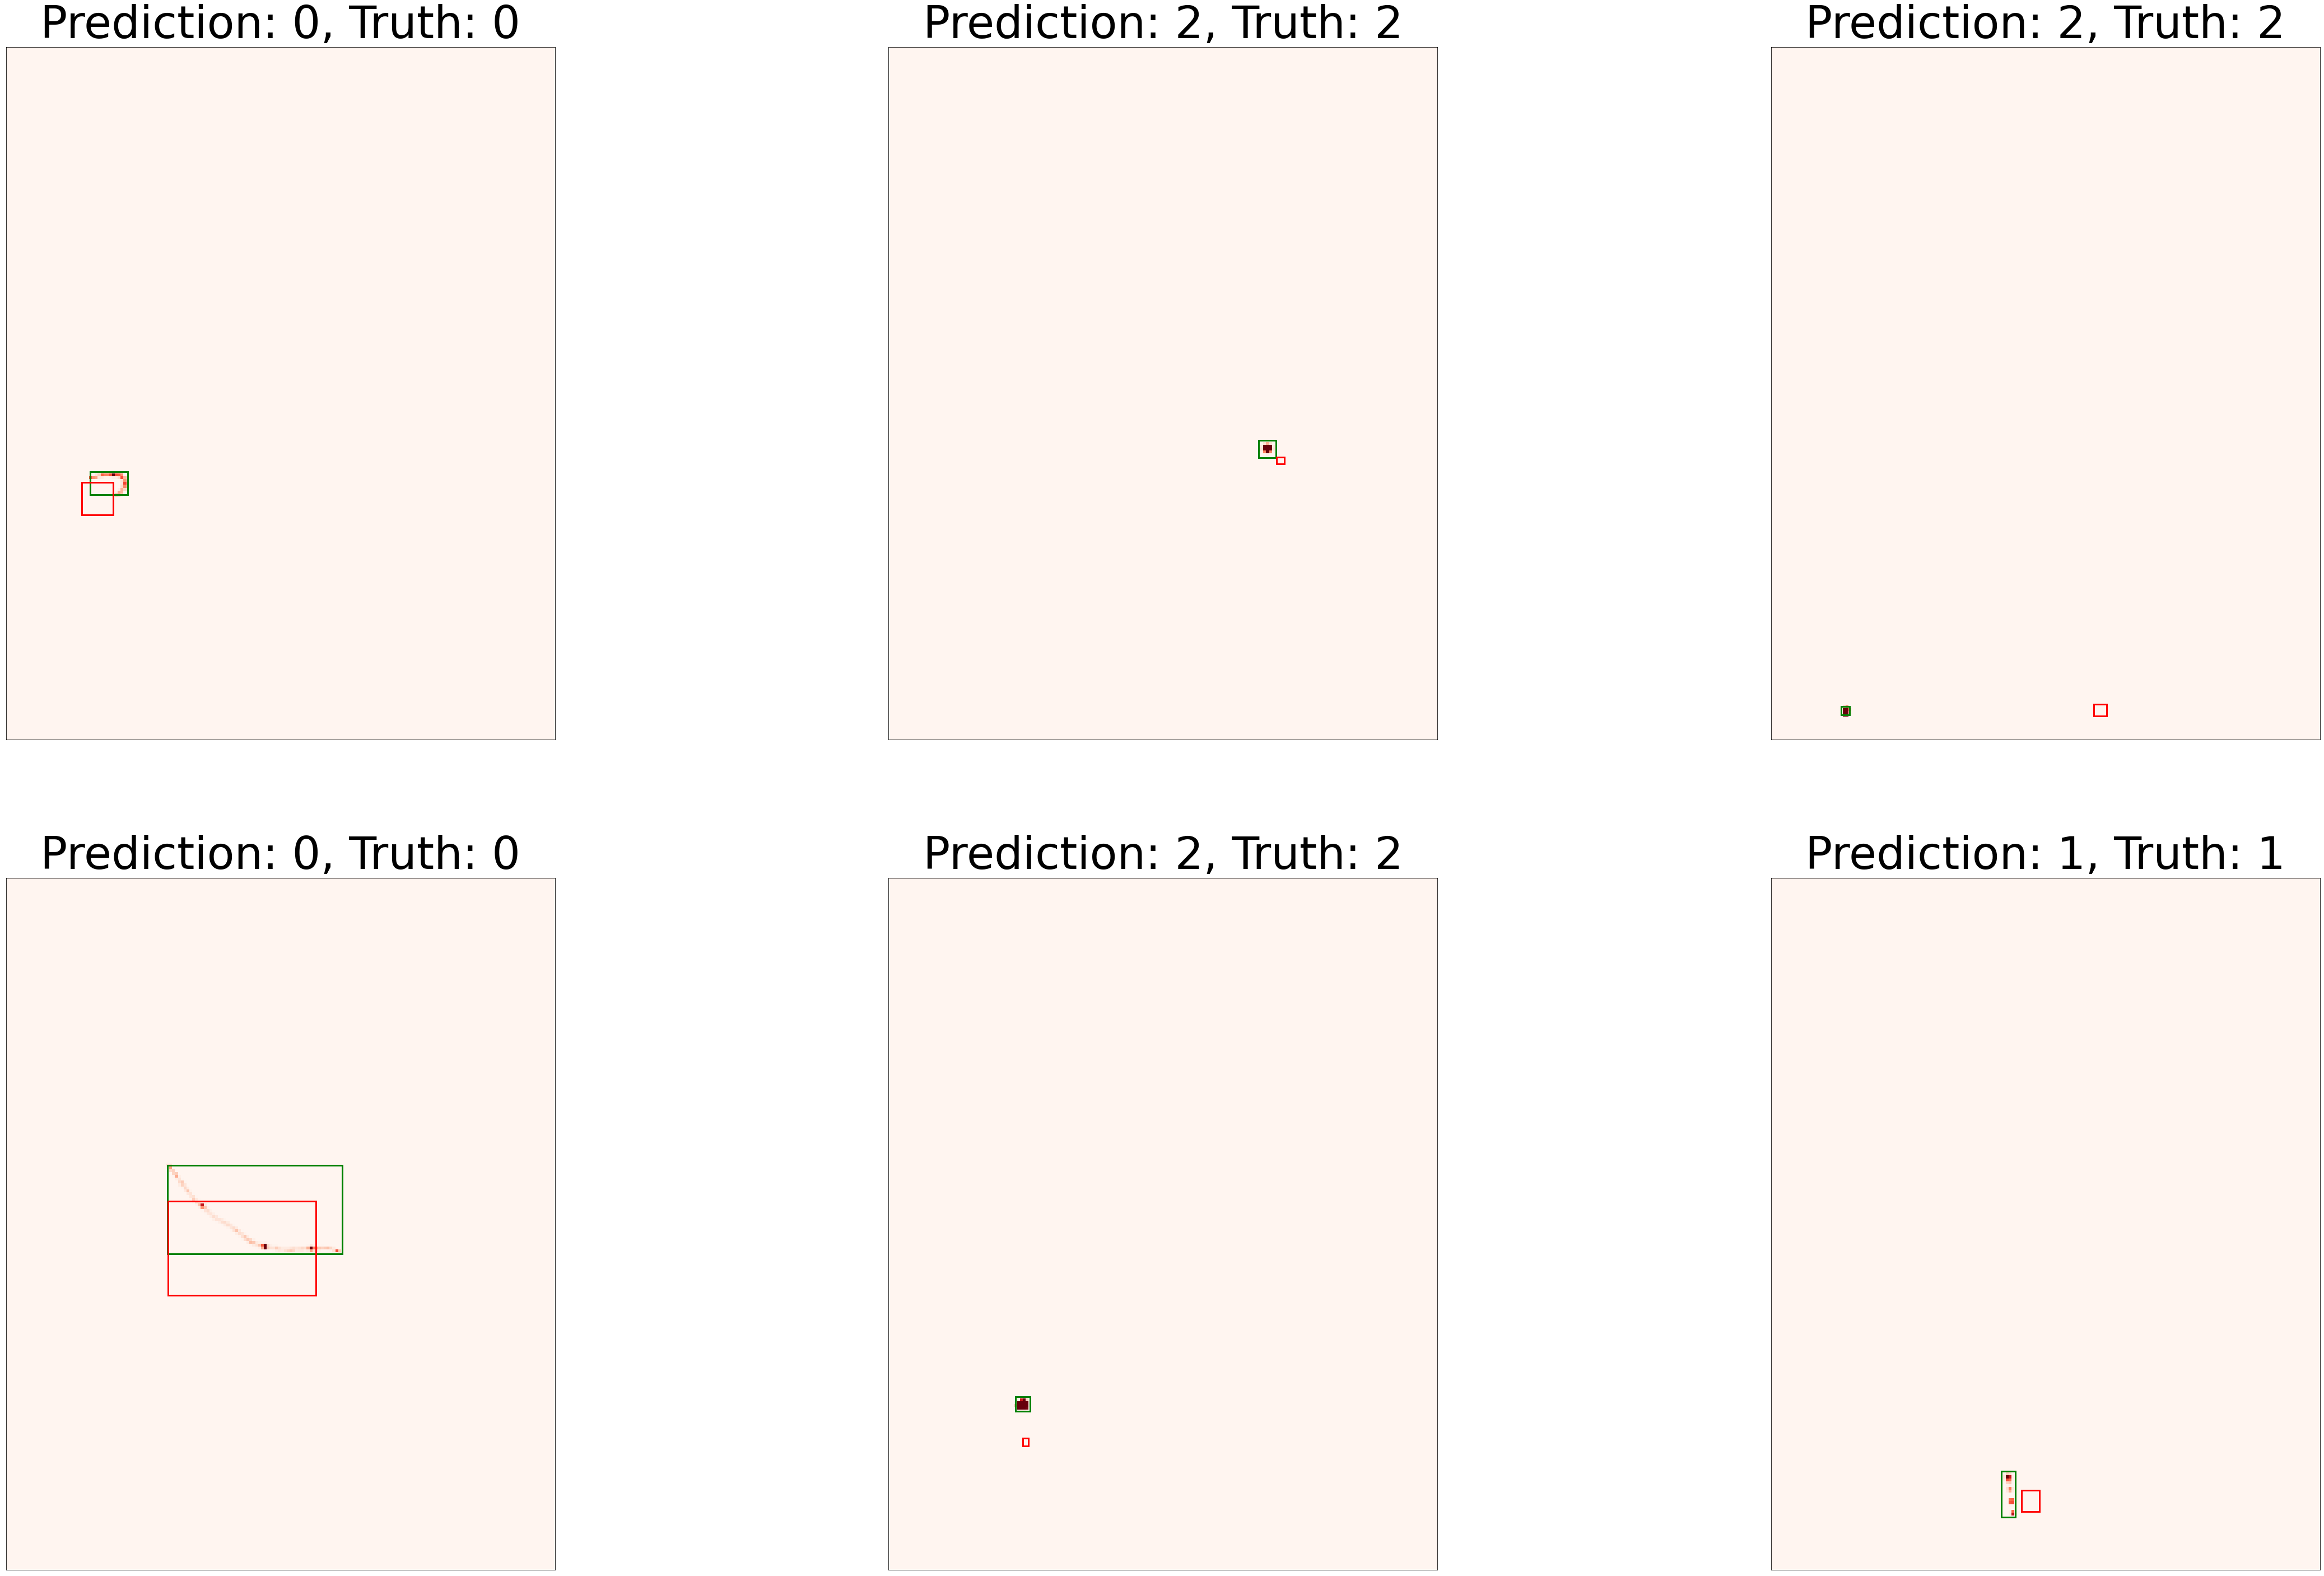

In [41]:
n = 3
plot_loc_class(n, y_pred1, y_labels1, loc_labels1_, loc_pred1_)

### Model 2: 2002 neurons, callbacks

In [73]:
inputs = keras.Input(shape=(window_y, window_x, 1))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
block_output = layers.MaxPooling2D(2)(x)

out = layers.Flatten()(block_output)

x = layers.Dense(2002, activation='relu')(out)

output1 = layers.Dense(3, activation='softmax', name='output1')(x) #classes: electron, noise, muon

output2 = layers.Dense(4)(x) #x, y, height, width
output2 = layers.LeakyReLU(alpha=0.3, name='output2')(output2)

model2 = keras.Model(input=inputs, output=[output1, output2], name='model_2')
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 242, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 240, 190, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 120, 95, 32)  0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 118, 93, 32)  9248        max_pooling2d_16[0][0]           
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_2", inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [74]:
losses={'output1': 'categorical_crossentropy', 'output2': l2}
alpha = 0.855
lossWeights = {"output1": alpha, "output2": 1-alpha}

model2.compile(optimizer=optimizers.RMSprop(lr= 1e-4), loss= losses, 
              loss_weights= lossWeights, metrics=["accuracy"])

In [75]:
H2 = model2.fit_generator(train_gen, validation_data=val_gen ,epochs=40, 
                         steps_per_epoch= 171, validation_steps= 56, callbacks = my_callbacks)

Epoch 1/40
171/171 [==============================] - 33s 192ms/step - loss: 11.7656 - output1_loss: 0.9532 - output2_loss: 75.5217 - output1_accuracy: 0.4528 - output2_accuracy: 0.8660 - val_loss: 4.5445 - val_output1_loss: 0.9138 - val_output2_loss: 32.9600 - val_output1_accuracy: 0.5441 - val_output2_accuracy: 0.8739
Epoch 2/40
171/171 [==============================] - 29s 169ms/step - loss: 4.3583 - output1_loss: 0.8976 - output2_loss: 24.7644 - output1_accuracy: 0.5556 - output2_accuracy: 0.9063 - val_loss: 4.9381 - val_output1_loss: 0.8926 - val_output2_loss: 21.3508 - val_output1_accuracy: 0.5684 - val_output2_accuracy: 0.9369
Epoch 3/40
171/171 [==============================] - 27s 157ms/step - loss: 3.3418 - output1_loss: 0.8925 - output2_loss: 17.7839 - output1_accuracy: 0.5520 - output2_accuracy: 0.9289 - val_loss: 3.0670 - val_output1_loss: 0.8829 - val_output2_loss: 18.3051 - val_output1_accuracy: 0.5695 - val_output2_accuracy: 0.9361
Epoch 4/40
171/171 [================

In [76]:
loss_t, loss_1, loss_2, acc_1, acc_2 = model2.evaluate_generator(test_gen, steps=58)
print('Accuracy for classification: {:5.2f}%'.format(100*acc_1))

Accuracy for classification: 70.66%


In [77]:
model2.save('models/e_mu_a_Loc2.h5')

In [78]:
pred2 = model2.predict_generator(test_generator_XY2(X), steps=58)

y_pred2 = pred2[0] #predicted classification 
y_pred2 = np.argmax(y_pred2, axis=1)

loc_pred2 = pred2[1] #predicted location

In [79]:
#data distribution
X_energy = get_energy()

#true classification labels
y_labels2 = gen_true_y()

#true localization labels
loc_labels2 = gen_true_loc()

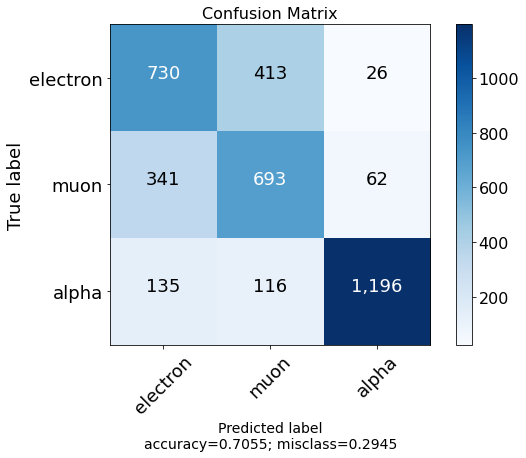

In [80]:
conf1 = confusion_matrix(y_labels2, y_pred2, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf1, 
                      normalize    = False,
                      target_names = ['electron', 'muon','alpha'],
                      title        = "Confusion Matrix")

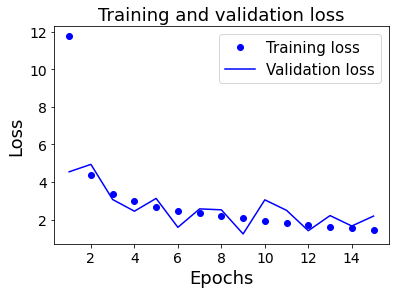

In [81]:
history_n1 = H2.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

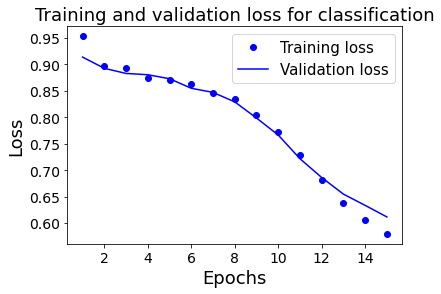

In [82]:
history_n1 = H2.history
loss_values_n1 = history_n1['output1_loss']
val_loss_values_n1 = history_n1['val_output1_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for classification', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

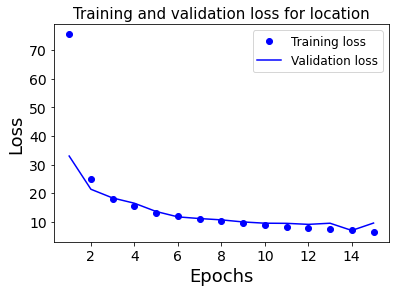

In [83]:
history_n1 = H2.history
loss_values_n1 = history_n1['output2_loss']
val_loss_values_n1 = history_n1['val_output2_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for location', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [84]:
print(classification_report(y_labels2, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

    electron       0.61      0.62      0.61      1169
        muon       0.57      0.63      0.60      1096
       alpha       0.93      0.83      0.88      1447

    accuracy                           0.71      3712
   macro avg       0.70      0.69      0.70      3712
weighted avg       0.72      0.71      0.71      3712



In [85]:
loc_pred2_ = loc_pred2 * std_loc + m_loc
loc_labels2_ = loc_labels2 * std_loc + m_loc

In [86]:
I_o_U(loc_labels2_, loc_pred2_)

0.12084140454773529

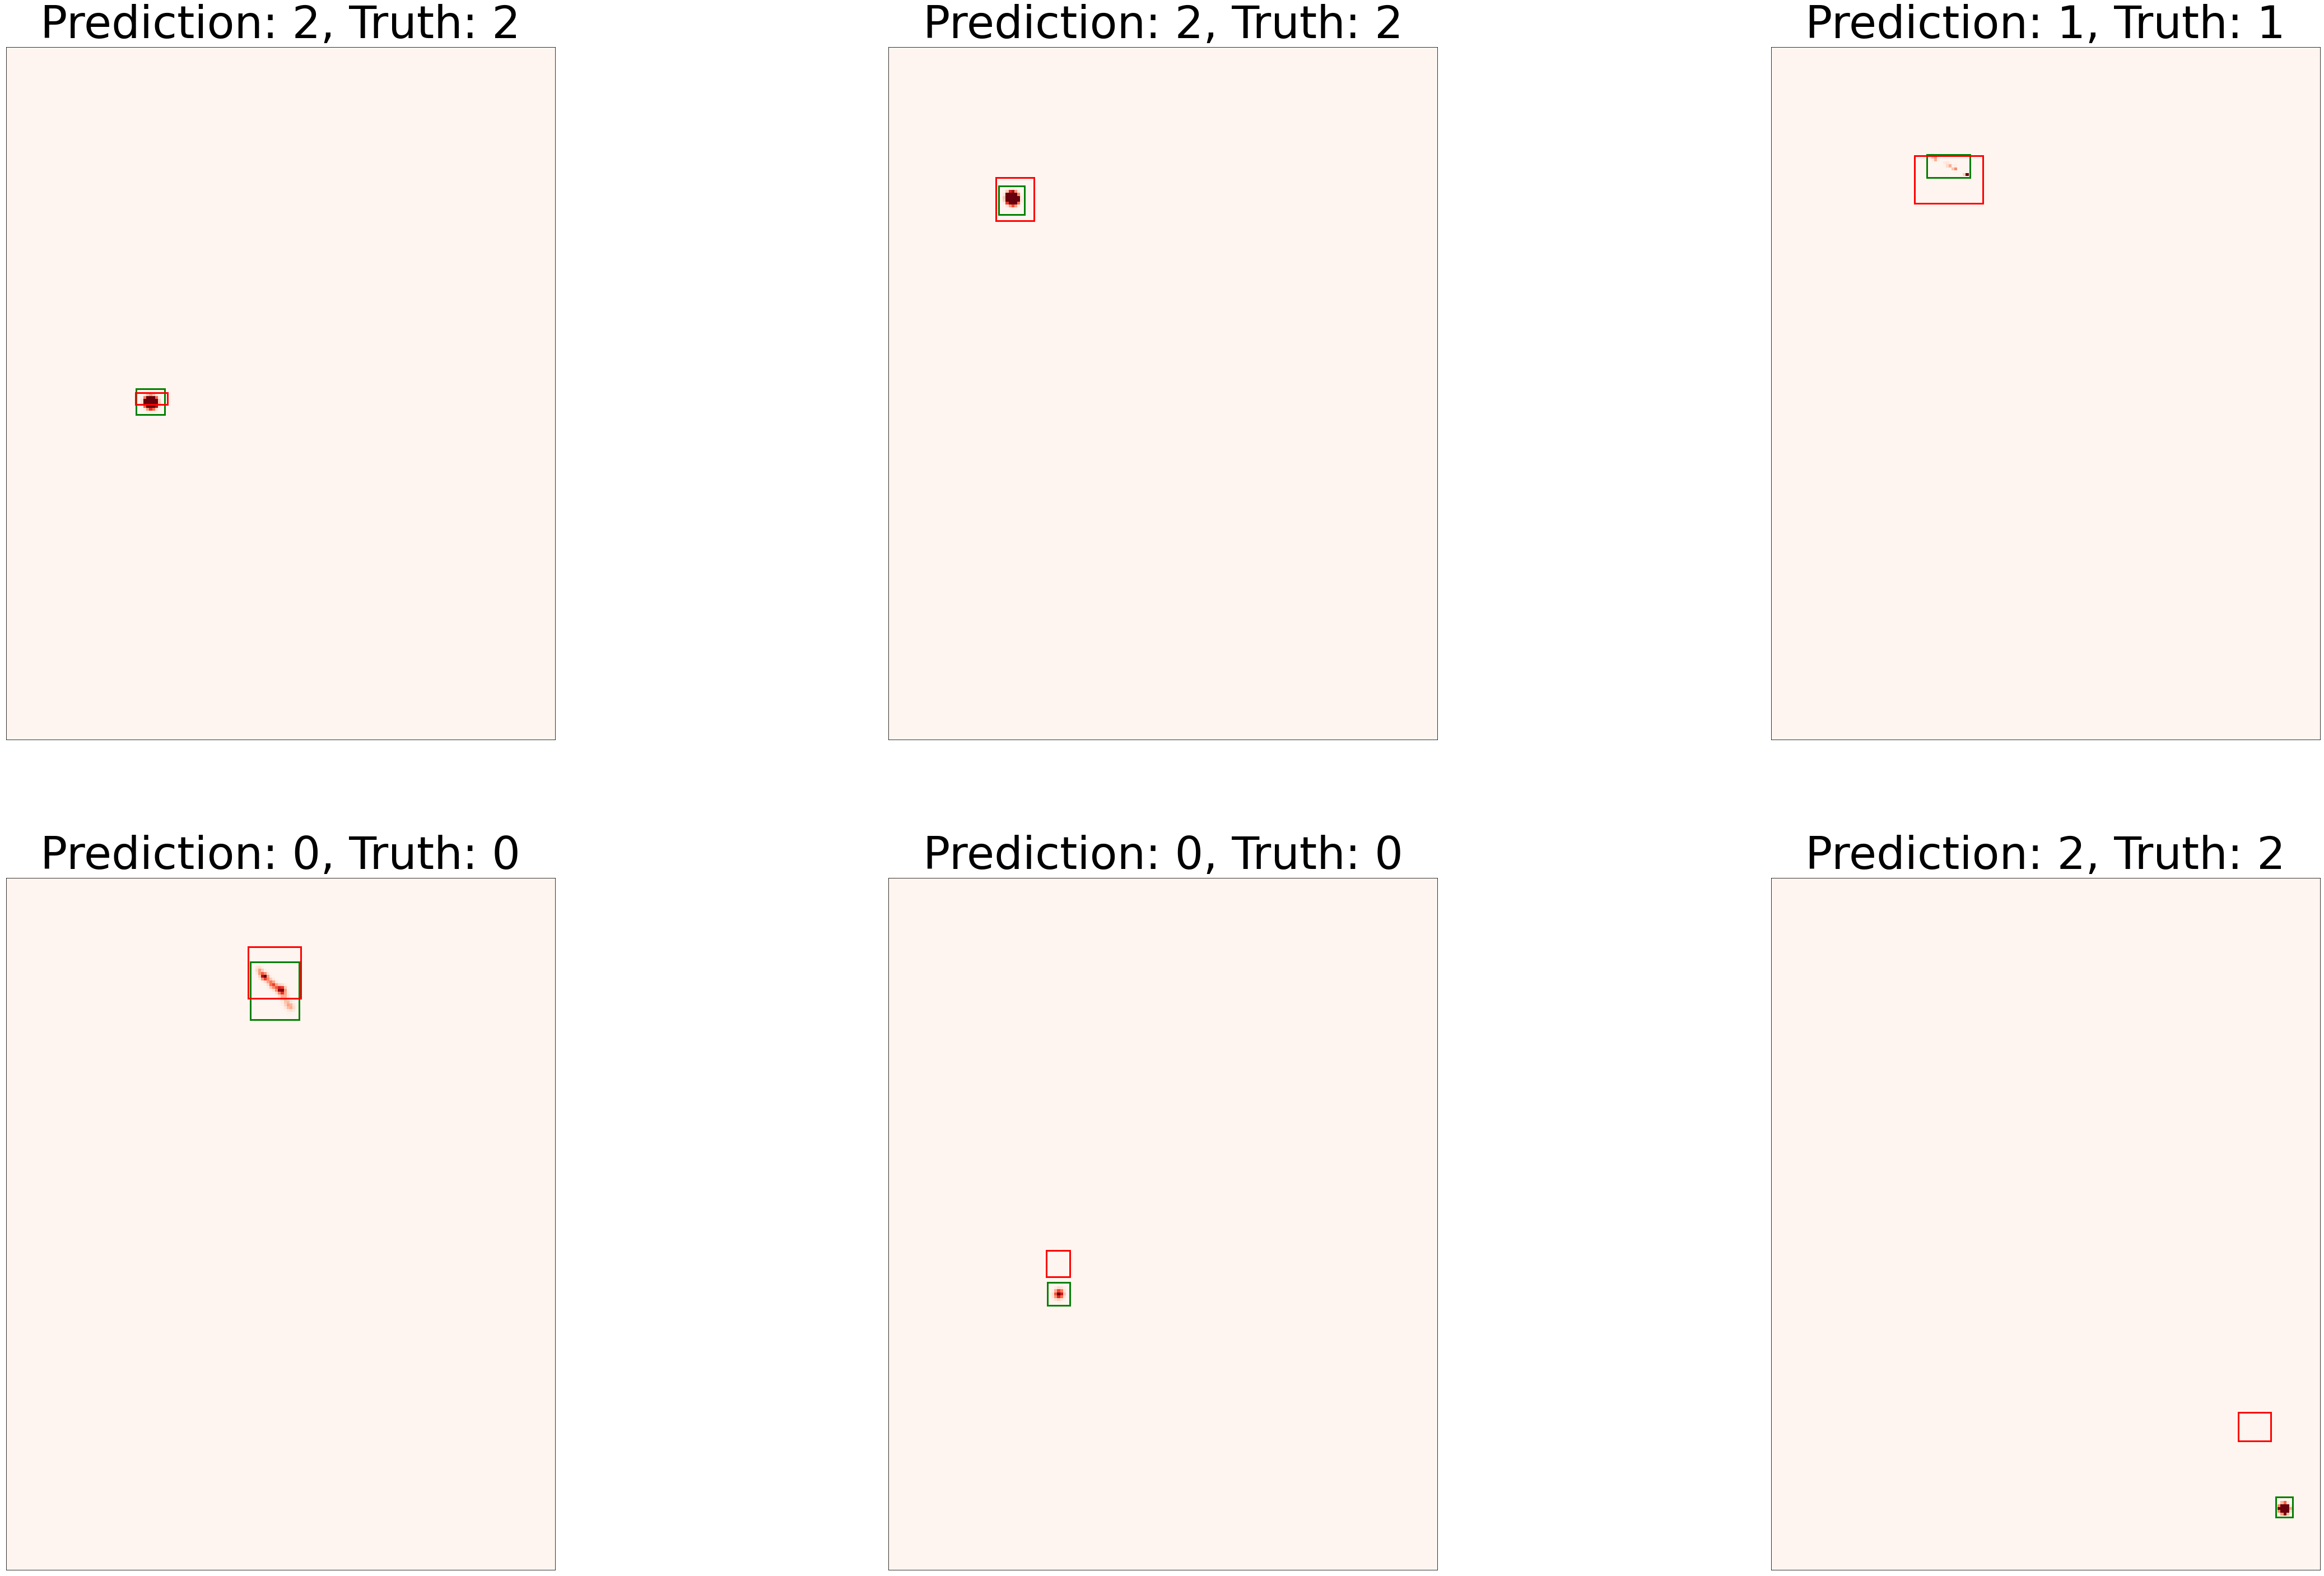

In [87]:
n = 3
plot_loc_class(n, y_pred2, y_labels2, loc_labels2_, loc_pred2_)

### Model 4: 1002 neurons, 202 neurons for localization, dropouts, callbacks

In [157]:
inputs = keras.Input(shape=(window_y, window_x, 1))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
block_output = layers.MaxPooling2D(2)(x)


out = layers.Flatten()(block_output)

x = layers.Dropout(0.5)(out)
x = layers.Dense(1002, activation='relu')(x)
x = layers.Dropout(0.25)(x)

output1 = layers.Dense(3, activation='softmax', name='output1')(x) #classes: electron, noise, muon

output2 = layers.Dense(202, activation='relu')(x)
output2 = layers.Dense(4, #activity_regularizer= keras.regularizers.l2(0.001), 
                       )(output2) #x, y, height, width
output2 = layers.LeakyReLU(alpha=0.3, name='output2')(output2)

model4 = keras.Model(input=inputs, output=[output1, output2], name='model_1')
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 242, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 240, 190, 32) 320         input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_66 (MaxPooling2D) (None, 120, 95, 32)  0           conv2d_66[0][0]                  
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 118, 93, 32)  9248        max_pooling2d_66[0][0]           
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_1", inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [158]:
losses={'output1': 'categorical_crossentropy', 'output2': l2}
alpha = 0.855
lossWeights = {"output1": alpha, "output2": 1-alpha}

In [159]:
model4.compile(optimizer=optimizers.RMSprop(lr= 1e-4), loss= losses, 
              loss_weights= lossWeights, metrics=["accuracy"])

In [160]:
my_callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=6)
]

In [161]:
#TRAIN
H4 = model4.fit_generator(train_gen, validation_data=val_gen ,epochs=40, 
                         steps_per_epoch= 171, validation_steps= 56, callbacks = my_callbacks)

Epoch 1/40
171/171 [==============================] - 29s 169ms/step - loss: 15.2667 - output1_loss: 1.0309 - output2_loss: 99.2088 - output1_accuracy: 0.3942 - output2_accuracy: 0.8353 - val_loss: 9.4575 - val_output1_loss: 0.9820 - val_output2_loss: 52.6233 - val_output1_accuracy: 0.4997 - val_output2_accuracy: 0.8608
Epoch 2/40
171/171 [==============================] - 28s 165ms/step - loss: 5.4726 - output1_loss: 0.9647 - output2_loss: 32.0532 - output1_accuracy: 0.4936 - output2_accuracy: 0.8943 - val_loss: 5.0227 - val_output1_loss: 0.9361 - val_output2_loss: 22.2237 - val_output1_accuracy: 0.5329 - val_output2_accuracy: 0.9149
Epoch 3/40
171/171 [==============================] - 27s 155ms/step - loss: 4.1304 - output1_loss: 0.9422 - output2_loss: 22.9298 - output1_accuracy: 0.5146 - output2_accuracy: 0.9141 - val_loss: 3.5433 - val_output1_loss: 0.9186 - val_output2_loss: 22.2840 - val_output1_accuracy: 0.5285 - val_output2_accuracy: 0.9261
Epoch 4/40
171/171 [================

In [164]:
model4.save('models/e_mu_a_Loc4.h5')

In [163]:
loss_t, loss_1, loss_2, acc_1, acc_2 = model4.evaluate_generator(test_gen, steps=58)
print('Accuracy for classification: {:5.2f}%'.format(100*acc_1))

Accuracy for classification: 73.28%


In [251]:
pred4 = model4.predict_generator(test_generator_XY2(X), steps=58)

y_pred4 = pred4[0] #predicted classification 
y_pred4 = np.argmax(y_pred4, axis=1)

loc_pred4 = pred4[1] #predicted location

In [252]:
#data distribution
X_energy = get_energy()

#true classification labels
y_labels4 = gen_true_y()

#true localization labels
loc_labels4 = gen_true_loc()

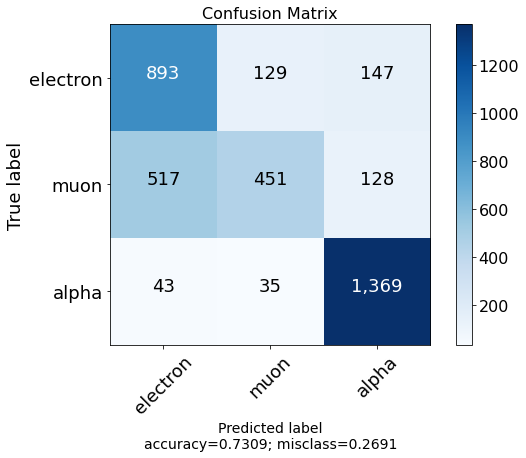

In [253]:
conf2 = confusion_matrix(y_labels4, y_pred4, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

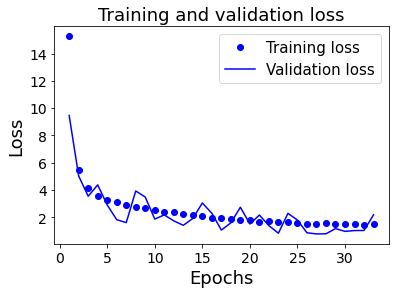

In [167]:
history_n1 = H4.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [168]:
print(classification_report(y_labels4, y_pred4, target_names=target_names))

              precision    recall  f1-score   support

    electron       0.61      0.76      0.68      1169
        muon       0.73      0.41      0.53      1096
       alpha       0.83      0.95      0.89      1447

    accuracy                           0.73      3712
   macro avg       0.73      0.71      0.70      3712
weighted avg       0.73      0.73      0.72      3712



In [169]:
loc_pred4_ = loc_pred4 * std_loc + m_loc
loc_labels4_ = loc_labels4 * std_loc + m_loc

In [170]:
I_o_U(loc_labels4_, loc_pred4_)

0.24700406743934142

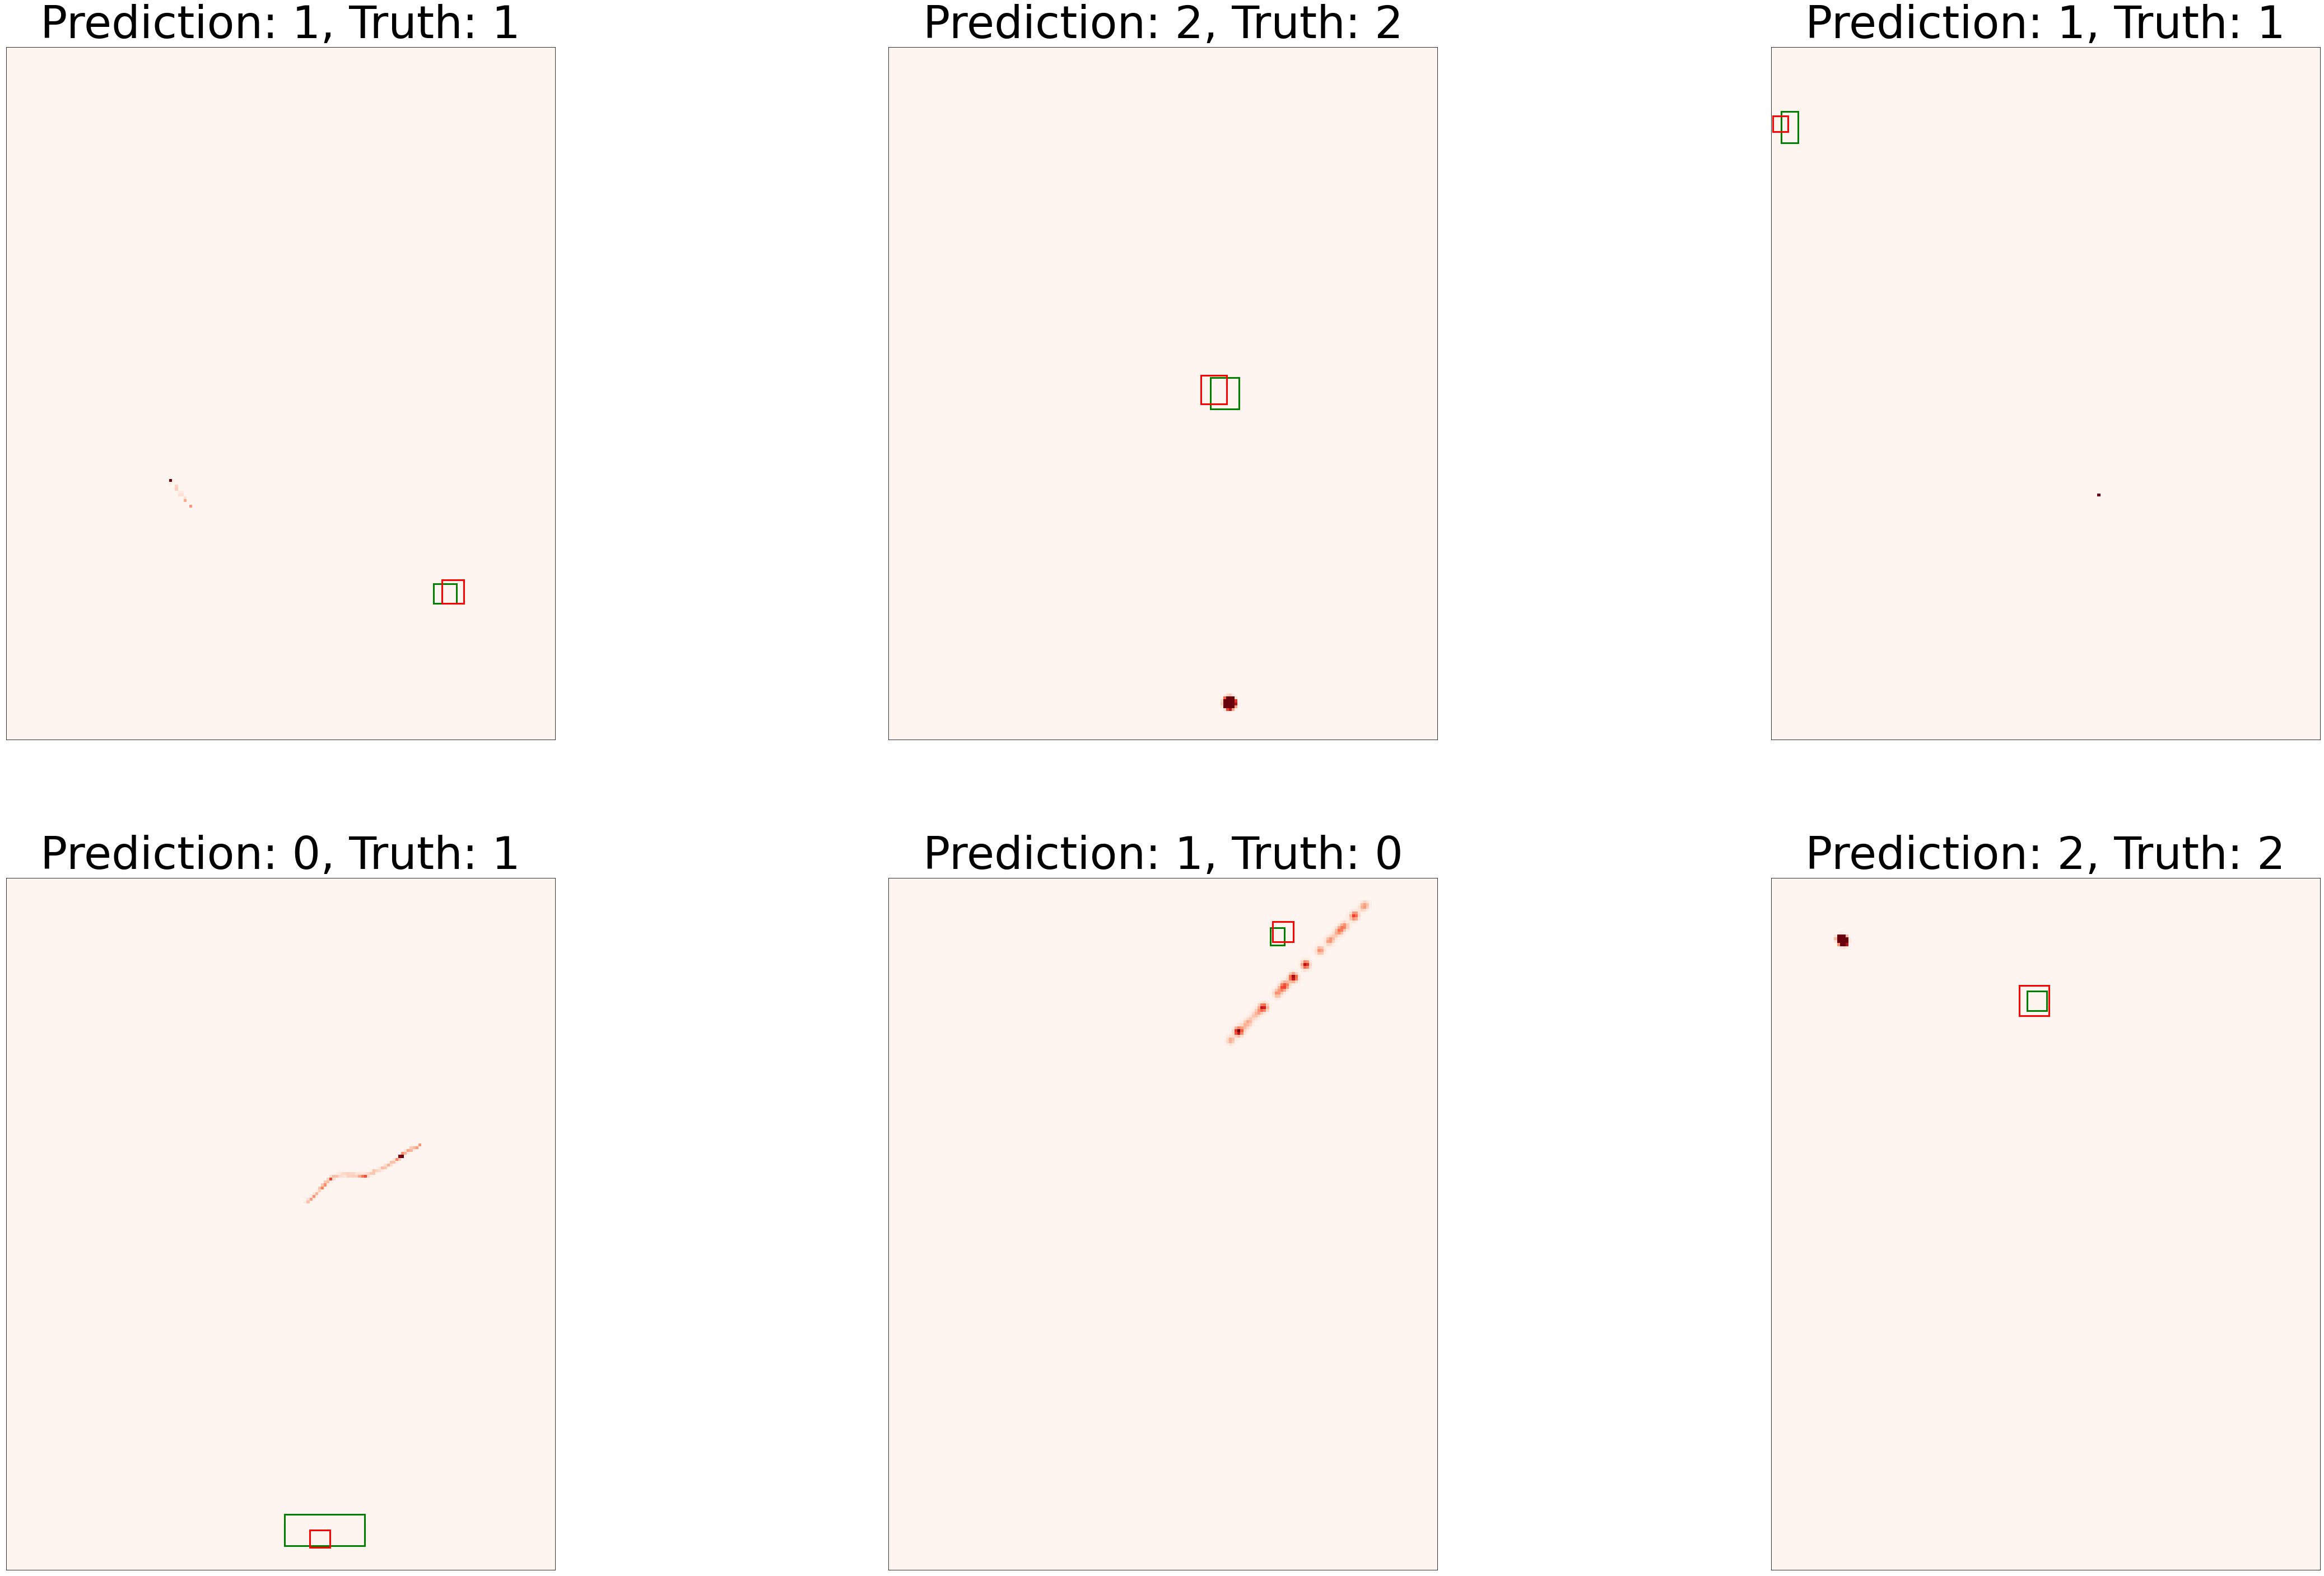

In [254]:
plot_loc_class(3, y_labels4, y_pred4, loc_labels4_, loc_pred4_)

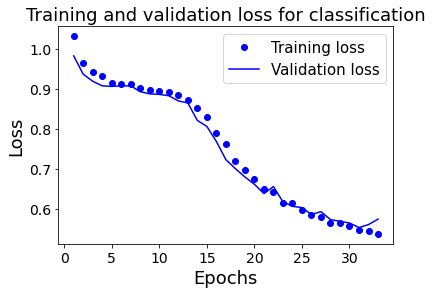

In [172]:
history_n1 = H4.history
loss_values_n1 = history_n1['output1_loss']
val_loss_values_n1 = history_n1['val_output1_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for classification', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

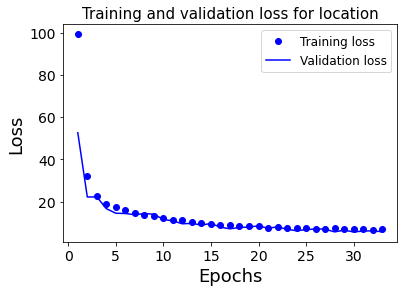

In [173]:
history_n1 = H4.history
loss_values_n1 = history_n1['output2_loss']
val_loss_values_n1 = history_n1['val_output2_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for location', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Model 5: 3002 neurons, callbacks (best model)

In [11]:
inputs = keras.Input(shape=(window_y, window_x, 1))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
block_output = layers.MaxPooling2D(2)(x)

out = layers.Flatten()(block_output)


x = layers.Dense(3002, activation='relu')(out)

output1 = layers.Dense(3, activation='softmax', name='output1')(x) #classes: electron, noise, muon

output2 = layers.Dense(4)(x) #x, y, height, width
output2 = layers.LeakyReLU(alpha=0.3, name='output2')(output2)

model5 = keras.Model(input=inputs, output=[output1, output2], name='model_5')
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 242, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 240, 190, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 120, 95, 32)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 118, 93, 32)  9248        max_pooling2d_6[0][0]            
____________________________________________________________________________________________

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="model_5", inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [59]:
losses={'output1': 'categorical_crossentropy', 'output2': l2}
alpha = 0.855
lossWeights = {"output1": alpha, "output2": 1-alpha}

my_callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=6)
]

model5.compile(optimizer=optimizers.RMSprop(lr= 1e-4), loss= losses, 
              loss_weights= lossWeights, metrics=["accuracy"])

In [60]:
#TRAIN
H5 = model5.fit_generator(train_gen, validation_data=val_gen ,epochs=40, 
                         steps_per_epoch= 171, validation_steps= 56, callbacks = my_callbacks)

Epoch 1/40
171/171 [==============================] - 29s 172ms/step - loss: 10.9065 - output1_loss: 0.9738 - output2_loss: 69.4756 - output1_accuracy: 0.4487 - output2_accuracy: 0.8637 - val_loss: 3.5967 - val_output1_loss: 0.9207 - val_output2_loss: 26.0832 - val_output1_accuracy: 0.5432 - val_output2_accuracy: 0.9224
Epoch 2/40
171/171 [==============================] - 31s 183ms/step - loss: 4.2540 - output1_loss: 0.9085 - output2_loss: 23.9813 - output1_accuracy: 0.5462 - output2_accuracy: 0.9129 - val_loss: 3.1462 - val_output1_loss: 0.8988 - val_output2_loss: 20.8917 - val_output1_accuracy: 0.5505 - val_output2_accuracy: 0.9330
Epoch 3/40
171/171 [==============================] - 29s 169ms/step - loss: 3.3359 - output1_loss: 0.8924 - output2_loss: 17.7442 - output1_accuracy: 0.5436 - output2_accuracy: 0.9294 - val_loss: 2.4059 - val_output1_loss: 0.8824 - val_output2_loss: 19.1256 - val_output1_accuracy: 0.5393 - val_output2_accuracy: 0.9395
Epoch 4/40
171/171 [================

In [61]:
model5.save('models/e_mu_a_Loc5.h5')

In [62]:
loss_t, loss_1, loss_2, acc_1, acc_2 = model5.evaluate_generator(test_gen, steps=58)
print('Accuracy for classification: {:5.2f}%'.format(100*acc_1))

Accuracy for classification: 76.43%


In [63]:
pred5 = model5.predict_generator(test_generator_XY2(X), steps=58)

y_pred5 = pred5[0] #predicted classification 
y_pred5 = np.argmax(y_pred5, axis=1)

loc_pred5 = pred5[1] #predicted location

In [64]:
#data distribution
X_energy = get_energy()

#true classification labels
y_labels5 = gen_true_y()

#true localization labels
loc_labels5 = gen_true_loc()

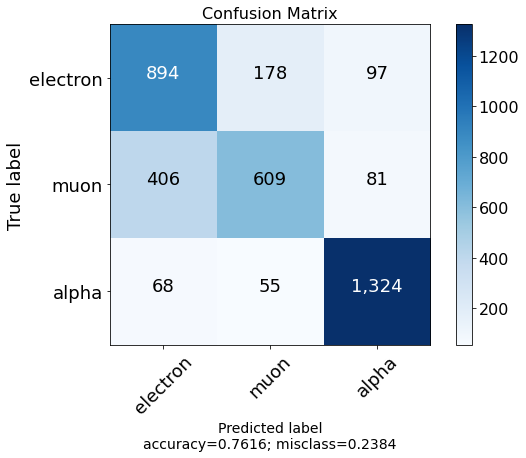

In [65]:
conf2 = confusion_matrix(y_labels5, y_pred5, labels = list([0,1,2]))
plot_confusion_matrix(cm           = conf2, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")

In [66]:
loc_pred5_ = loc_pred5 * std_loc + m_loc
loc_labels5_ = loc_labels5 * std_loc + m_loc

In [67]:
I_o_U(loc_labels5_, loc_pred5_)

0.2922349950291863

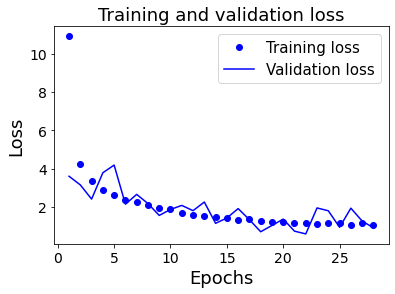

In [68]:
history_n1 = H5.history
loss_values_n1 = history_n1['loss']
val_loss_values_n1 = history_n1['val_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

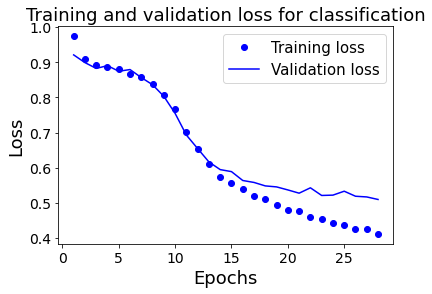

In [69]:
history_n1 = H5.history
loss_values_n1 = history_n1['output1_loss']
val_loss_values_n1 = history_n1['val_output1_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for classification', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

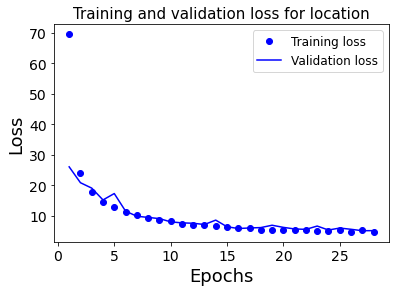

In [70]:
history_n1 = H5.history
loss_values_n1 = history_n1['output2_loss']
val_loss_values_n1 = history_n1['val_output2_loss']
epochs_n1 = range(1, len(loss_values_n1) + 1)
plt.plot(epochs_n1, loss_values_n1, 'bo', label='Training loss')
plt.plot(epochs_n1, val_loss_values_n1, 'b', label='Validation loss')
plt.title('Training and validation loss for location', fontsize=15)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [71]:
print(classification_report(y_labels5, y_pred5, target_names=target_names))

              precision    recall  f1-score   support

    electron       0.65      0.76      0.70      1169
        muon       0.72      0.56      0.63      1096
       alpha       0.88      0.91      0.90      1447

    accuracy                           0.76      3712
   macro avg       0.75      0.75      0.74      3712
weighted avg       0.76      0.76      0.76      3712



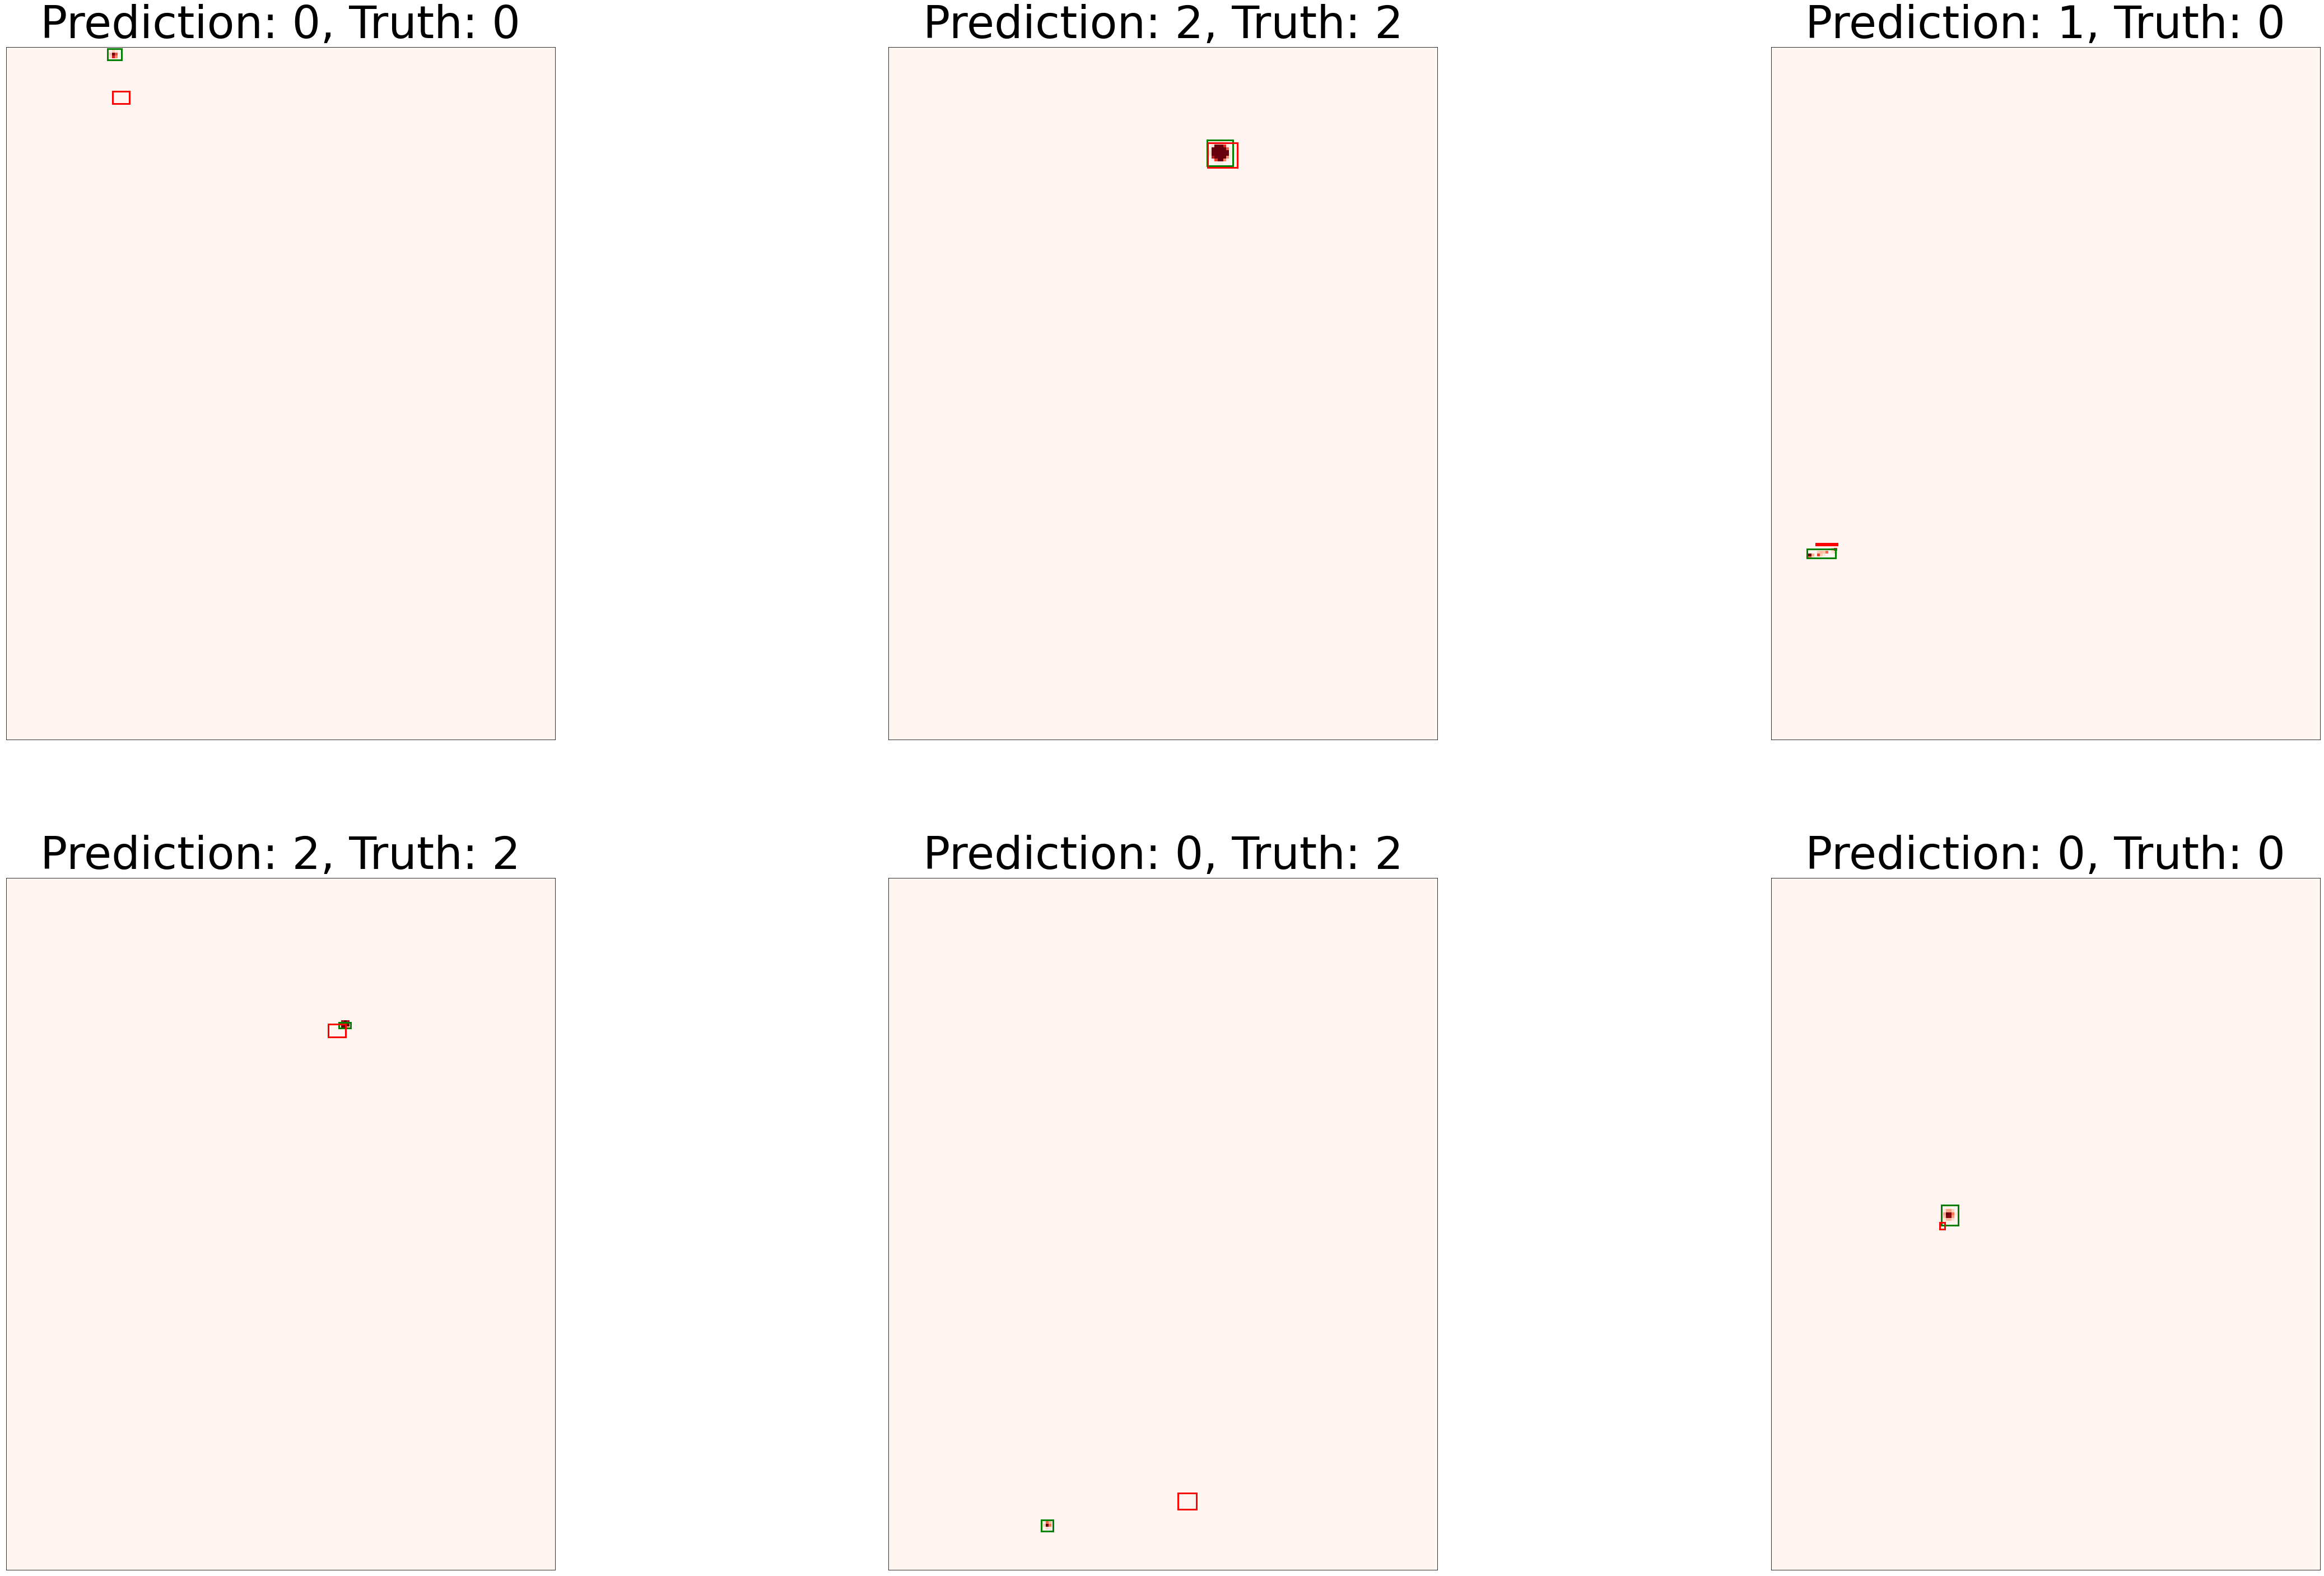

In [72]:
plot_loc_class(3, y_labels5, y_pred5, loc_labels5_, loc_pred5_)

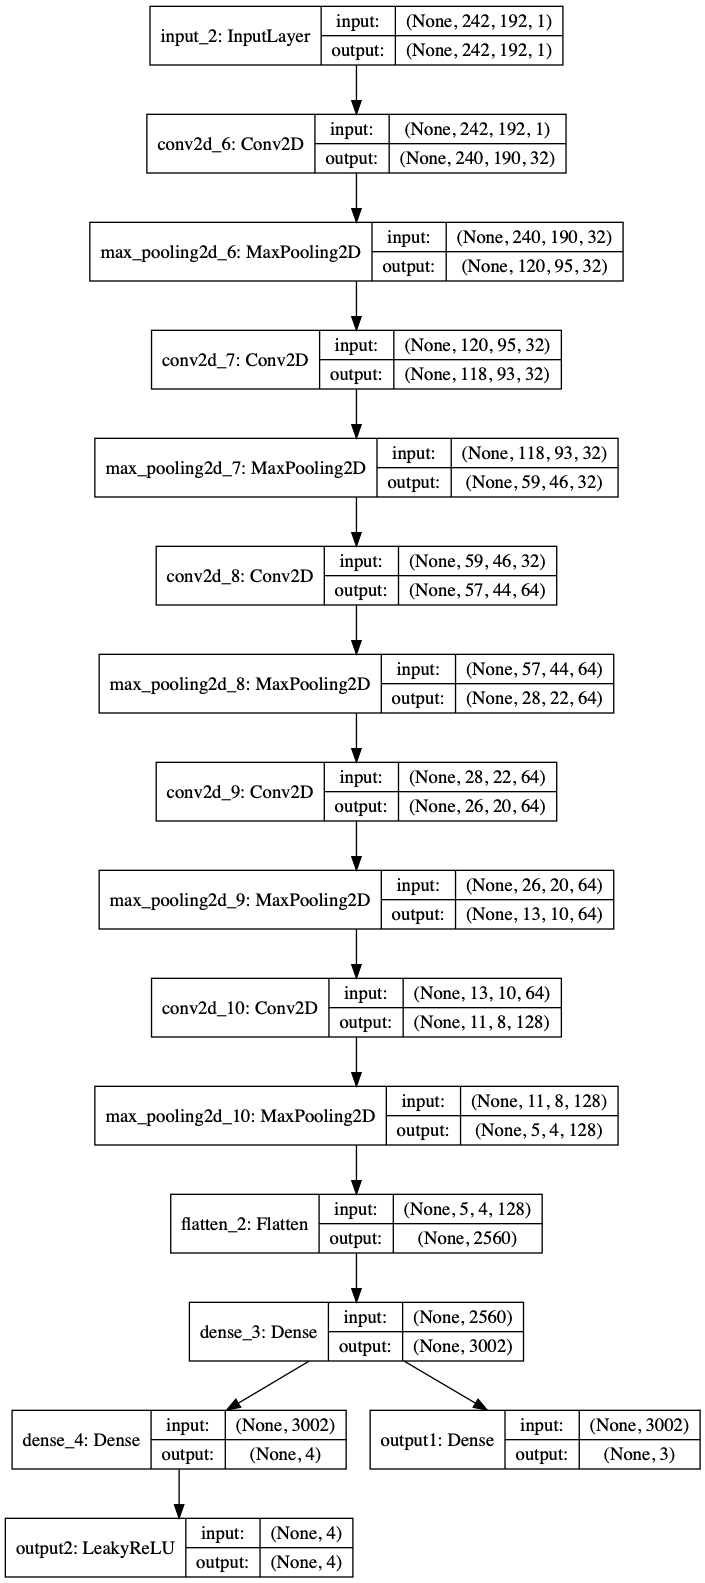

In [12]:
keras.utils.plot_model(model5, 'models/model5.png', show_shapes=True)